In [1]:
import keras
import pdb
import gc
import requests

In [2]:
!pip install mat73
!pip install Bayesian-Optimization
!pip install h5py

In [3]:
from google.colab import drive
import mat73
import h5py
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from sklearn.model_selection import train_test_split, cross_val_score
import statistics as st

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
dataset = mat73.loadmat('/content/drive/MyDrive/CNN_Chagas/Chagas/data/Dataset_Raw.mat')

In [6]:
signals = list(dataset['Dataset_Raw'])

output = []
for i in range(0, len(signals)):
    output.append(signals[i][-1])
    signals[i] = np.delete(signals[i], [-1,-2])
    # signals[i] = signals[i][0:1000]

In [7]:
count = [0,0,0]
for i in output:
  if i < 0.4:
    count[0] += 1
  elif 0.4<= i <0.5:
    count[1] += 1
  else:
    count[2] +=1

In [8]:
count

[50, 61, 108]

In [9]:
maximum = 100
for i, signal in enumerate(signals):
  count = 0
  for j, val in enumerate(signal):
    if val == 0:
      count += 1
    else:
      count = 0

    if count == maximum:
      signals[i] = signal[0: j-maximum+1]
      break

In [10]:
def discrete_ratio(ratio_set, n):
    classes = list(range(1, n+1))
    ratio = 1.0/n

    for j in range(0, len(ratio_set)):
        for i in range(0, n):
            if ratio_set[j] > ratio*i and ratio_set[j] <= ratio*(i+1):
                ratio_set[j] = int(classes[i])
                break

    return ratio_set

In [11]:
output = discrete_ratio(output, 2)

In [12]:
with open('Sinais_Chagas.txt') as f:
    lines = f.readlines()

idx = []

for i in range(0, len(lines)):
  arq = lines[i][lines[i].find('FileName1 = '):lines[i].find('\n')]
  signal = lines[i][lines[i].find('Signals{'):lines[i].find('\n')]
  signal = signal[signal.find('{')+1 : signal.find('}')]

  if arq != '':
    idx.append(arq[13:-2])
  if signal != '':
     idx.append(signal)

idx = idx[:-3]


pairs = []
for i in range(0, len(idx), 2):
  val = [idx[i+1], idx[i]]
  pairs.append(val)

In [13]:
matriz_pontos = []
for i in pairs:
    url =  str(i[1]) + '_MatrizPontos.mat'
    pontos = sio.loadmat(url)
    matriz_pontos.append(pontos["Matriz_Pontos"])

In [14]:
beats = []
classes =[]

for i in range(len(matriz_pontos)):
    signal = []
    for j in range(len(matriz_pontos[i])):
        beat_ini = matriz_pontos[i][j][0]
        beat_end = matriz_pontos[i][j][-1]
        beat = signals[i][beat_ini:beat_end+1]
        signal.append(beat)

    beats.append(signal)
    classes.append(output[i])

In [15]:
def rm_outliers(vector):
    lengths = []
    for i in vector:
        if len(i) != 0:
            lengths.append(len(i))

    lengths.sort()
    size = len(lengths)

    q1 = lengths[round(0.25*size) - 1]
    q3 = lengths[round(0.75*size) - 1]
    iqr = q3-q1
    linf = q1 - 1.5*iqr
    lsup = q3 + 1.5*iqr

    new_vec = []
    for i in vector:
        if len(i) >= linf and len(i) <=lsup:
            new_vec.append(i)

    #pdb.set_trace()
    if new_vec == []:
        pdb.set_trace()

    return new_vec

In [16]:
def norm_len(signals):
    cont = -1
    lsup = len(max(signals, key = len))

    x = []

    for sig in signals:
        cont += 1

        n = math.floor(lsup) - len(sig)

        zeros = np.zeros(int(n))
        x.append(list(np.concatenate((sig, zeros), axis=None)))

    return x

In [17]:
def signals_med(array):
    array_size = len(array[0])
    array_qnt = len(array)
    md_vector = []

    for j in range(0, array_size):
        aux = []

        for i in range(0, array_qnt):
            aux.append(array[i][j])

        md_vector.append(st.median(aux))

    return md_vector

In [18]:
def del_var(samples, median_sig):
    results = []

    for sample in samples:
        val = 0
        for i in range (len(sample)):
            val += (sample[i] - median_sig[i])**2

        if val <= st.variance(median_sig):
            results.append(sample)

    return results

In [19]:
del dataset, signal, matriz_pontos

In [20]:
new_beats = []
for samples in beats:
    samples = rm_outliers(samples)
    #samples = norm_len(samples)
    #median = signals_med(samples)
    #samples = del_var(samples, median)
    new_beats.append(samples)

In [21]:
#new_beats = np.load('/kaggle/input/monta-dataset-rawsignals-regressao/new_beats.npy', allow_pickle=True)

In [22]:
x_rem, x_test, y_rem, y_test = train_test_split(new_beats, classes, test_size=0.15, stratify=classes, random_state=38)
x_train, x_valid, y_train, y_valid = train_test_split(x_rem, y_rem, test_size=0.15, stratify=y_rem, random_state=38)

In [23]:
raw_x_test = x_test
raw_y_test = y_test

raw_x_valid = x_valid
raw_y_valid = y_valid

In [24]:
del new_beats, lines, idx, output, pairs, samples, signals, x_rem, y_rem, classes, beats

In [25]:
def split_beats(signals, classes, bps):
    result_s = []
    result_c = []
    for idx, signal in enumerate(signals):
        for i in range(0, len(signal)-bps, bps):
            result_s.append(signal[i:i+bps])
            result_c.append(classes[idx])

    return result_s, result_c

In [26]:
# bps= 300
bps = 200

In [27]:
x_train, y_train = split_beats(x_train, y_train, bps)
x_valid, y_valid = split_beats(x_valid, y_valid, bps)
x_test, y_test = split_beats(x_test, y_test, bps)

In [28]:
len(x_train[0])

200

In [29]:
def mix_beats(x_, y_):
    x = []
    c = []

    for i in range(len(x_)):
        for j in range(len(x_[i])):
            x.append(x_[i][j])
            c.append(y_[i])

    return x, c

In [30]:
'''x_train, y_train = mix_beats(x_train, y_train)
x_valid, y_valid = mix_beats(x_valid, y_valid)
x_test, y_test = mix_beats(x_test, y_test)'''

'x_train, y_train = mix_beats(x_train, y_train)\nx_valid, y_valid = mix_beats(x_valid, y_valid)\nx_test, y_test = mix_beats(x_test, y_test)'

In [31]:
def get_max_size(vec):
    maximum = 0
    for i in vec:
        if maximum < len(max(i, key = len)):
            maximum = len(max(i, key = len))

    return maximum

In [32]:
'''tr = len(max(x_train, key = len))
v = len(max(x_valid, key = len))
te = len(max(x_test, key = len))
lim = max(v,tr,te)'''

'tr = len(max(x_train, key = len))\nv = len(max(x_valid, key = len))\nte = len(max(x_test, key = len))\nlim = max(v,tr,te)'

In [33]:
lim = get_max_size(x_train + x_valid + x_test)

In [34]:
def norm_len_2(s, lsup):

    for i, sig in enumerate(s):
        for j, beat in enumerate(sig):
            n = math.floor(lsup) - len(beat)

            zeros = np.zeros(int(n))
            s[i][j] = np.concatenate((beat, zeros), axis=None)

    return s

In [35]:
x_valid = norm_len_2(x_valid, lim)
x_train = norm_len_2(x_train, lim)
x_test = norm_len_2(x_test, lim)

In [36]:
del cross_val_score, f, sio, discrete_ratio, mat73, signals_med, get_max_size, i, j, beat, beat_end, beat_ini
del arq, bps, count, del_var, lim, maximum, mix_beats, norm_len, norm_len_2, pdb, pontos, requests, rm_outliers, split_beats
del train_test_split, url, val
gc.collect()

0

In [37]:
y_valid = pd.get_dummies(y_valid)
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [38]:
x_train = np.array(list(x_train))
x_valid = np.array(list(x_valid))
x_test = np.array(list(x_test))

In [39]:
x_train.shape

(9733, 200, 210)

In [40]:
'''x_train = x_train.reshape(-1, bps, x_train.shape[1])
x_valid = x_valid.reshape(x_valid.shape[0], bps, x_valid.shape[1])
x_test = x_test.reshape(x_test.shape[0], bps, x_test.shape[1])'''

'x_train = x_train.reshape(-1, bps, x_train.shape[1])\nx_valid = x_valid.reshape(x_valid.shape[0], bps, x_valid.shape[1])\nx_test = x_test.reshape(x_test.shape[0], bps, x_test.shape[1])'

In [41]:
inp_shape = (x_train.shape[1], x_train.shape[2])

In [42]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input, concatenate, Bidirectional
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, LSTM
from keras.initializers import Constant
from bayes_opt import BayesianOptimization
from bayes_opt.util import UtilityFunction

from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl



from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
import os

from sklearn import metrics
import tensorflow as tf

In [43]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

In [44]:
def network(lstm_layers, dense_layers, units, neurons_ini, optimizer, learning_rate, dropout):

    # Define custom initializers for kernel and bias
    '''kernel_init = Constant(value=0.1)
    matrix = np.full((units, 4*units), 0.1)
    matrix = gram_schmidt(matrix)
    matrix = Constant(value=matrix)'''


    classificador_1 = Sequential()

    for i in range(lstm_layers):
        if i == 0:
            classificador_1.add(LSTM(units=units, return_sequences = True,  activation='tanh',
                                     recurrent_activation='sigmoid', recurrent_dropout=0 ,
                                     input_shape=(inp_shape[0], inp_shape[1])))
        else:
            classificador_1.add(LSTM(units=units, return_sequences = True,  activation='tanh',
                                     recurrent_activation='sigmoid', recurrent_dropout=0))

    classificador_1.add(Flatten())

    for i in range(dense_layers):
        classificador_1.add(Dense(neurons_ini, activation='relu'))
        classificador_1.add(Dropout(dropout))
        neurons_ini = neurons_ini/2

    classificador_1.add(Dense(2, activation='softmax'))

    classificador_1.compile(loss='categorical_crossentropy', optimizer=optimizer(learning_rate=learning_rate), metrics=["accuracy"])

    return classificador_1

In [45]:
melhor = 0

In [46]:
import re

def extract_index(name):
    # Extract the index from the dataset name
    match = re.search(r"\d+$", name)
    if match:
        return int(match.group())
    else:
        return None

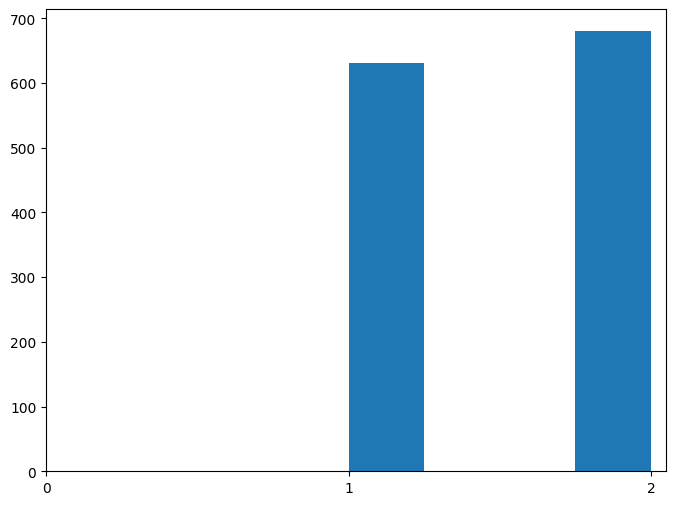

In [47]:
y_valid.idxmax(axis=1).hist(
    figsize=(8, 6),
    range = [1, 2],
    grid = False,
    bins = 4,
)
plt.xticks(range(3))
plt.show()

In [48]:
def evaluate_network(lstm_layers, dense_layers, units, neurons_ini, optimizer, batch_size, learning_rate, dropout):

    global y_valid, melhor


    lstm_layers = round(lstm_layers)
    dense_layers = round(dense_layers)
    units = 20*round(units)
    neurons_ini = 2**round(neurons_ini)
    optimizer = round(optimizer)
    batch_size = 2**round(batch_size)
    learning_rate = round(learning_rate)
    print(learning_rate)

    optimizer_array = [Adam, RMSprop, Adadelta, Adagrad, Adamax,SGD]
    optimizer_val = optimizer_array[optimizer]

    learn_array = [0.1, 0.01]
    learn_val = learn_array[learning_rate]

    model = network(lstm_layers, dense_layers, units, neurons_ini, optimizer_val, learn_val, dropout)
    # initial_weights = model.get_weights()

    filename = "initial_weights.h5"
    with h5py.File(filename, "r") as f:
        # Get the list of dataset objects
        datasets = [f[key] for key in f.keys() if isinstance(f[key], h5py.Dataset)]
        sorted_datasets = sorted(datasets, key=lambda ds: extract_index(ds.name))
        model.set_weights(sorted_datasets)

    es = EarlyStopping(monitor="val_accuracy", mode='max', verbose=0, patience=15)

    checkpoint = ModelCheckpoint('_pesos_lstm1.h5', monitor="val_accuracy", verbose=0,
                                      save_best_only=True, mode='max')

    history_1 = model.fit(x_train, y_train, validation_data = (x_valid, y_valid),
                                    epochs=200, batch_size = batch_size, callbacks=[checkpoint],
                                    verbose=0, use_multiprocessing=True, workers=8)

    model = load_model('_pesos_lstm1.h5')

    #plot history
    plt.rcParams['figure.figsize']=(20,5)
    plt.rcParams.update({'font.size': 20})

    plt.plot(history_1.history['accuracy'])
    plt.plot(history_1.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig("history.png")
    plt.show()

    #predict
    y_pred = model.predict(x_test)
    y_pred = pd.DataFrame(y_pred)
    y_pred.columns = [1, 2]
    y_pred = y_pred.idxmax(axis=1)
    y_te = y_test.idxmax(axis=1)

    #plot confusion matrix
    plt.rcParams['figure.figsize']=(2,2)
    plt.rcParams.update({'font.size': 10})

    flag = False
    for i in y_pred:
      if math.isnan(i):
        flag = True
        break

    if flag == False:
      cf_matrix = confusion_matrix(y_te, y_pred)
      cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['1','2'])
      cm_display.plot()
      plt.show()

      #display report
      relatorio = classification_report(y_te, y_pred, target_names = ['1','2'])
      print(relatorio)

      #calculating score
      y_pred = model.predict(x_valid)
      y_pred = (np.asarray(y_pred)).round()
      y_pred = y_pred.astype(int)
      y_val = np.array(y_valid)

      # score = accuracy_score(y_val, y_pred) * f1_score(y_val, y_pred, average='weighted')
      score = accuracy_score(y_val, y_pred)

      # if score > melhor:
      #   melhor = score
      #   model.save('/content/drive/MyDrive/CNN_Chagas/Chagas/LSTM/_melhores_pesos.h5')
      #   with h5py.File('/content/drive/MyDrive/CNN_Chagas/Chagas/LSTM/initial_weights.h5', 'w') as h5f:
      #       for i, weight in enumerate(initial_weights):
      #           h5f.create_dataset(f'weight_{i}', data=weight)


    else:
      score = 0
      with open('save.npy', 'wb') as f:
        np.save(f, np.array(y_pred))

    gc.collect()
    return model, score

In [ ]:
# kappas  = [3.5]
# for kappa in kappas:

#   pbounds = {'lstm_layers': (1, 4),
#             'dense_layers': (1, 4),
#             'units': (3, 8),
#             'neurons_ini': (5, 7),
#             'optimizer': (0, 5),
#             'batch_size': (6, 9),
#             'learning_rate': (0, 1),
#             'dropout': (0.3, 0.6)
#           }

#   optimizer = BayesianOptimization(
#       f=evaluate_network,
#       pbounds=pbounds,
#       verbose=2,  # verbose = 1 prints only when a maximum
#       # is observed, verbose = 0 is silent
#       random_state=1
#   )

#   print("kappa = ", kappa)
#   utility = UtilityFunction(kind='ucb', kappa=kappa)
#   optimizer.maximize(init_points=50, n_iter=190, acquisition_function=utility)

1


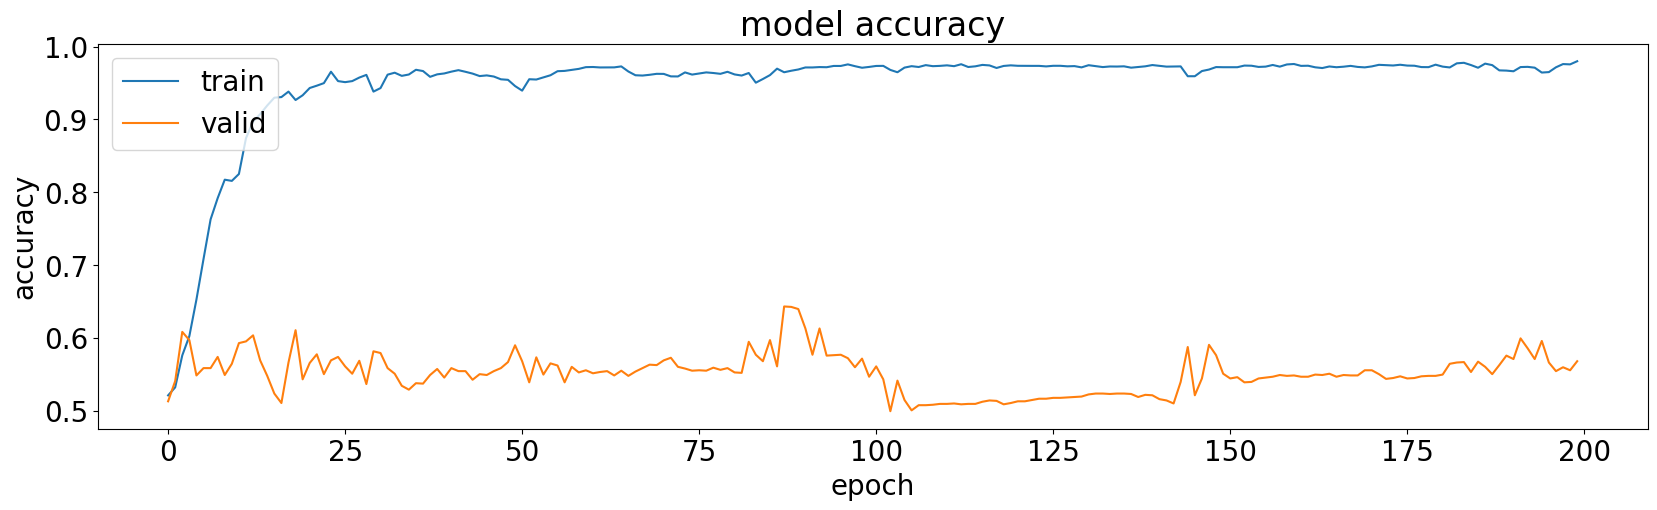

58/58 [==============================] - 2s 10ms/step


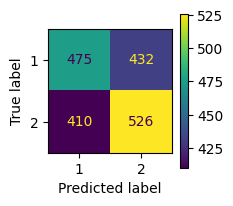

              precision    recall  f1-score   support

           1       0.54      0.52      0.53       907
           2       0.55      0.56      0.56       936

    accuracy                           0.54      1843
   macro avg       0.54      0.54      0.54      1843
weighted avg       0.54      0.54      0.54      1843

53/53 [==============================] - 0s 8ms/step


In [ ]:
# evaluate_network(batch_size = 6.267, dense_layers = 3.928 , dropout = 0.4027, learning_rate = 0.9463 , lstm_layers = 2.375 , neurons_ini = 5.145,
#                  optimizer = 4.466, units  = 5.031)

#7.174     | 2.517     | 0.5257    | 0.9912    | 1.403     | 6.825     | 0.4284    | 6.115
# evaluate_network(batch_size = 7.174, dense_layers = 2.517 , dropout = 0.5257, learning_rate = 0.9912 , lstm_layers = 1.403 , neurons_ini = 6.825,
#                  optimizer = 0.4284, units  = 6.115)

#  8.67      | 2.654     | 0.5151    | 0.5792    | 1.866     | 6.218     | 4.438     | 4.806
model, _ = evaluate_network(batch_size = 8.67, dense_layers = 2.654 , dropout = 0.5151, learning_rate = 0.5792 , lstm_layers = 1.866 , neurons_ini = 6.218,
                 optimizer = 4.438, units  = 4.806)

In [58]:
model = load_model('/content/_melhores_pesos.h5')

41/41 [==============================] - 1s 12ms/step


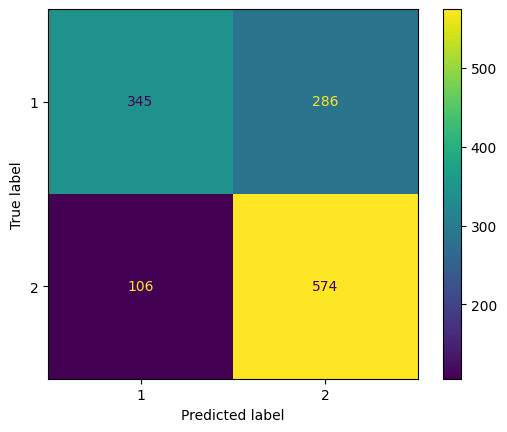

              precision    recall  f1-score   support

           1       0.76      0.55      0.64       631
           2       0.67      0.84      0.75       680

    accuracy                           0.70      1311
   macro avg       0.72      0.70      0.69      1311
weighted avg       0.71      0.70      0.69      1311



In [59]:
y_pred = model.predict(x_valid)

y_pred = pd.DataFrame(y_pred)
y_pred.columns = [1, 2]
y_pred = y_pred.idxmax(axis=1)

y_te = pd.DataFrame(y_valid)
y_te.columns = [1, 2]
y_te = y_te.idxmax(axis=1)

cf_matrix = confusion_matrix(y_te, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['1','2'])
cm_display.plot()
plt.show()

relatorio = classification_report(y_te, y_pred, target_names = ['1','2'])
print(relatorio)

In [52]:
def print_history(history, n):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('accuracy ' + str(n))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    # plt.savefig('plot '+classe+'.png')
    plt.show()

In [53]:
def generate_report(classificador, x_valid, y_valid, columns):
  y_pred = classificador.predict(x_valid)
  y_pred = pd.DataFrame(y_pred)
  y_pred.columns = columns
  y_pred = y_pred.idxmax(axis=1)

  y_valid = pd.DataFrame(y_valid)
  y_valid.columns = columns
  y_valid = y_valid.idxmax(axis=1)

  relatorio = classification_report(y_valid, y_pred)
  print(relatorio)

In [49]:
class AdaBoost:

    def __init__(self):
        self.alphas = []
        self.G_M = []
        self.M = None
        self.training_errors = []
        self.prediction_errors = []

    def __not_eq(self, a, b):
      if np.array_equal(a, b):
        return 0
      else:
        return 1

    def __idmax(self, y_pred):
      result = []
      for val in y_pred:
        idx = np.argmax(val)
        aux = np.zeros(len(val))
        aux[idx] = 1
        result.append(aux)

      return np.array(result)

    def __compute_error(self, y, y_pred, w_i):
        error = 0
        for i in range(len(y)):
          error += w_i[i] * self.__not_eq(y[i], y_pred[i])
        error = error/sum(w_i)
        return error

    def __compute_alpha(self, error):
        return np.log((1 - error) / error)

    def __update_weights(self, w_i, alpha, y, y_pred):
        return w_i * np.exp(alpha * (self.__not_eq(y, y_pred)))

    def fit(self, x, y, validation_data=None, M=100, epochs=None, batch_size=None, callbacks=None):

        # Clear before calling
        self.alphas = []
        self.training_errors = []
        self.M = M
        best_acc = []
        best_h = []
        best_G = []

        # Iterate over M weak classifiers
        for m in range(0, M):

            # Set weights for current boosting iteration
            if m == 0:
                w_i = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
            else:
                # (d) Update w_i
                w_i = self.__update_weights(w_i, alpha_m, y, y_pred)

            # (a) Fit weak classifier and predict labels

            #G_m = create_cnn(self.optimizer)
            G_m = load_model("_melhores_pesos.h5")


            checkpoint = ModelCheckpoint('_pesos_cnn1d.hdf5', monitor="val_accuracy", verbose=1,
                                      save_best_only=True, mode='max')

            history = G_m.fit(x, y, sample_weight = w_i, validation_data=validation_data,
                    epochs=epochs, batch_size=batch_size, callbacks=[checkpoint, callbacks])

            print_history(history, m)

            G_m = load_model('_pesos_cnn1d.hdf5')

            os.remove('_pesos_cnn1d.hdf5')
            # open('_pesos_cnn1d.hdf5', 'w').close()

            #Calcula a acurácia sobre a validação
            y_pred = G_m.predict(validation_data[0])

            idx = np.argmax(y_pred, axis=-1)
            y_pred = np.zeros( y_pred.shape )
            y_pred[ np.arange(y_pred.shape[0]), idx] = 1

            acc= accuracy_score(validation_data[1], y_pred)

            best_acc.append(acc)
            best_h.append(history)
            best_G.append(G_m)


            # if m == 0 or (acc > best_acc):
            #   best_acc = acc
            #   best_G = G_m
            #   best_h = history

            y_pred = G_m.predict(x)
            y_pred = self.__idmax(y_pred)

            self.G_M.append(G_m) # Save to list of weak classifiers

            # (b) Compute error
            error_m = self.__compute_error(y, y_pred, w_i)
            self.training_errors.append(error_m)

            # (c) Compute alpha
            alpha_m = self.__compute_alpha(error_m)
            self.alphas.append(alpha_m)

        assert len(self.G_M) == len(self.alphas)

        return best_G, best_h, best_acc

    def predict(self, x):

        # Initialise dataframe with weak predictions for each observation
        weak_preds = pd.DataFrame(index = range(len(x)), columns = range(self.M))

        # Predict class label for each weak classifier, weighted by alpha_m
        for m in range(self.M):
            y_pred_m = self.G_M[m].predict(x) * self.alphas[m]
            for i in range(weak_preds.shape[0]):
              weak_preds.iloc[i,m] = y_pred_m[i]

        # Calculate final predictions
        y_pred = weak_preds.T.sum()
        y_pred =  self.__idmax(y_pred)

        return y_pred

In [50]:
columns = y_train.columns

Int64Index([1, 2], dtype='int64')
Epoch 1/100
153/153 [==============================] - ETA: 0s - loss: 6.1252e-05 - accuracy: 0.8527
Epoch 1: val_accuracy improved from -inf to 0.69489, saving model to _pesos_cnn1d.hdf5
153/153 [==============================] - 10s 42ms/step - loss: 6.1252e-05 - accuracy: 0.8527 - val_loss: 9.8031 - val_accuracy: 0.6949
Epoch 2/100
153/153 [==============================] - ETA: 0s - loss: 5.9450e-05 - accuracy: 0.8487
Epoch 2: val_accuracy improved from 0.69489 to 0.69565, saving model to _pesos_cnn1d.hdf5
153/153 [==============================] - 4s 27ms/step - loss: 5.9450e-05 - accuracy: 0.8487 - val_loss: 9.7227 - val_accuracy: 0.6957
Epoch 3/100
153/153 [==============================] - ETA: 0s - loss: 5.7843e-05 - accuracy: 0.8473
Epoch 3: val_accuracy improved from 0.69565 to 0.69641, saving model to _pesos_cnn1d.hdf5
153/153 [==============================] - 5s 29ms/step - loss: 5.7843e-05 - accuracy: 0.8473 - val_loss: 9.6372 - val_accu

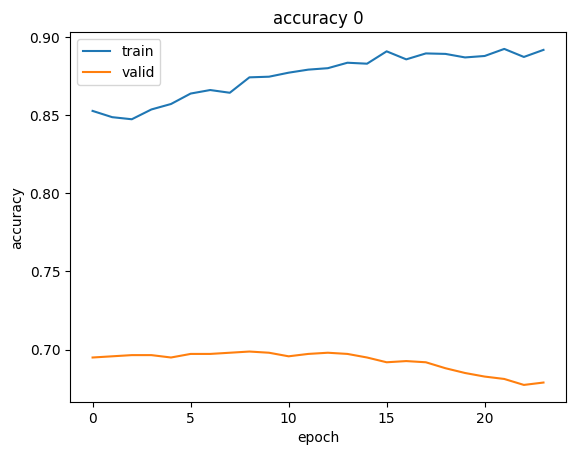

305/305 [==============================] - 3s 9ms/step
Epoch 1/100
152/153 [============================>.] - ETA: 0s - loss: 6.1498e-04 - accuracy: 0.8605
Epoch 1: val_accuracy improved from -inf to 0.69641, saving model to _pesos_cnn1d.hdf5
153/153 [==============================] - 8s 32ms/step - loss: 6.1472e-04 - accuracy: 0.8606 - val_loss: 9.2461 - val_accuracy: 0.6964
Epoch 2/100
153/153 [==============================] - ETA: 0s - loss: 4.4679e-04 - accuracy: 0.8759
Epoch 2: val_accuracy improved from 0.69641 to 0.69718, saving model to _pesos_cnn1d.hdf5
153/153 [==============================] - 4s 26ms/step - loss: 4.4679e-04 - accuracy: 0.8759 - val_loss: 8.9011 - val_accuracy: 0.6972
Epoch 3/100
151/153 [============================>.] - ETA: 0s - loss: 3.9998e-04 - accuracy: 0.8813
Epoch 3: val_accuracy did not improve from 0.69718
153/153 [==============================] - 4s 24ms/step - loss: 3.9946e-04 - accuracy: 0.8814 - val_loss: 8.6757 - val_accuracy: 0.6972
Epoch 

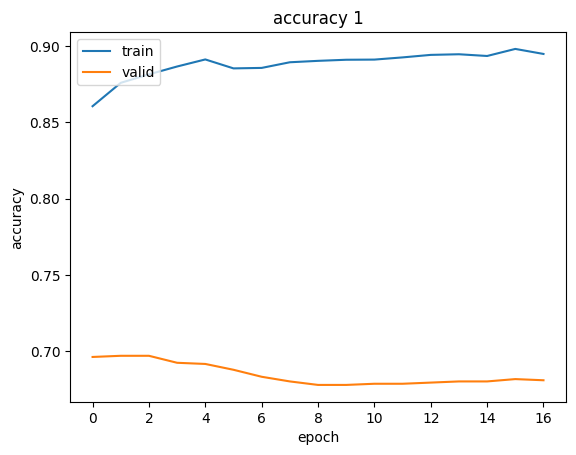

305/305 [==============================] - 3s 9ms/step
Epoch 1/100
153/153 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.8852
Epoch 1: val_accuracy improved from -inf to 0.68726, saving model to _pesos_cnn1d.hdf5
153/153 [==============================] - 8s 31ms/step - loss: 0.0047 - accuracy: 0.8852 - val_loss: 8.4606 - val_accuracy: 0.6873
Epoch 2/100
151/153 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 0.8916
Epoch 2: val_accuracy did not improve from 0.68726
153/153 [==============================] - 4s 25ms/step - loss: 0.0042 - accuracy: 0.8914 - val_loss: 8.3860 - val_accuracy: 0.6827
Epoch 3/100
153/153 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.8915
Epoch 3: val_accuracy did not improve from 0.68726
153/153 [==============================] - 4s 25ms/step - loss: 0.0042 - accuracy: 0.8915 - val_loss: 8.6301 - val_accuracy: 0.6812
Epoch 4/100
151/153 [============================>.] - ETA: 0s - loss

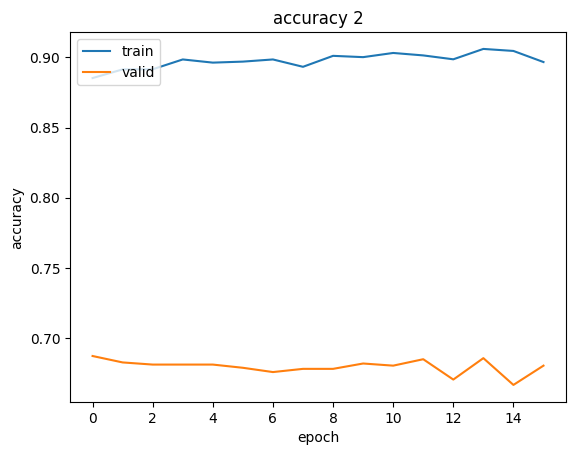

305/305 [==============================] - 3s 9ms/step
Epoch 1/100
152/153 [============================>.] - ETA: 0s - loss: 0.0779 - accuracy: 0.8829
Epoch 1: val_accuracy improved from -inf to 0.65675, saving model to _pesos_cnn1d.hdf5
153/153 [==============================] - 8s 32ms/step - loss: 0.0779 - accuracy: 0.8830 - val_loss: 11.0110 - val_accuracy: 0.6568
Epoch 2/100
153/153 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.8973
Epoch 2: val_accuracy did not improve from 0.65675
153/153 [==============================] - 4s 24ms/step - loss: 0.0699 - accuracy: 0.8973 - val_loss: 10.7927 - val_accuracy: 0.6552
Epoch 3/100
151/153 [============================>.] - ETA: 0s - loss: 0.0682 - accuracy: 0.8997
Epoch 3: val_accuracy did not improve from 0.65675
153/153 [==============================] - 4s 25ms/step - loss: 0.0681 - accuracy: 0.8999 - val_loss: 11.9805 - val_accuracy: 0.6323
Epoch 4/100
151/153 [============================>.] - ETA: 0s - l

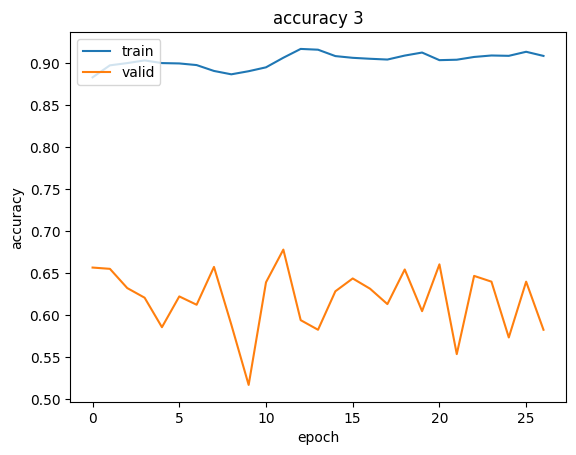

305/305 [==============================] - 3s 9ms/step
Epoch 1/100
153/153 [==============================] - ETA: 0s - loss: 2.2255 - accuracy: 0.8441
Epoch 1: val_accuracy improved from -inf to 0.60717, saving model to _pesos_cnn1d.hdf5
153/153 [==============================] - 8s 33ms/step - loss: 2.2255 - accuracy: 0.8441 - val_loss: 11.3540 - val_accuracy: 0.6072
Epoch 2/100
153/153 [==============================] - ETA: 0s - loss: 1.8491 - accuracy: 0.8801
Epoch 2: val_accuracy did not improve from 0.60717
153/153 [==============================] - 4s 24ms/step - loss: 1.8491 - accuracy: 0.8801 - val_loss: 5.9118 - val_accuracy: 0.4378
Epoch 3/100
151/153 [============================>.] - ETA: 0s - loss: 1.7555 - accuracy: 0.8891
Epoch 3: val_accuracy did not improve from 0.60717
153/153 [==============================] - 4s 24ms/step - loss: 1.7555 - accuracy: 0.8890 - val_loss: 11.2611 - val_accuracy: 0.5545
Epoch 4/100
151/153 [============================>.] - ETA: 0s - lo

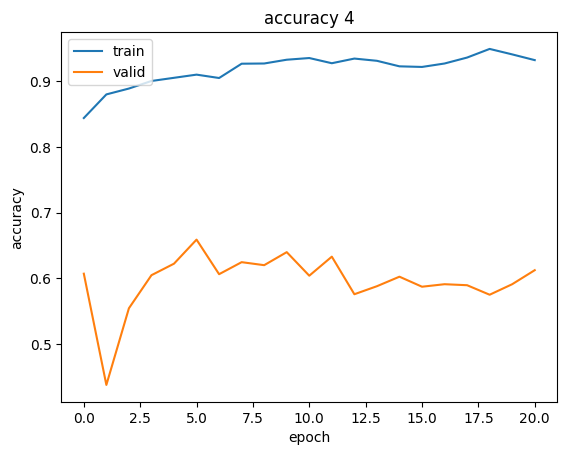

305/305 [==============================] - 3s 8ms/step
Epoch 1/100
153/153 [==============================] - ETA: 0s - loss: 51.7973 - accuracy: 0.8613
Epoch 1: val_accuracy improved from -inf to 0.57818, saving model to _pesos_cnn1d.hdf5
153/153 [==============================] - 9s 32ms/step - loss: 51.7973 - accuracy: 0.8613 - val_loss: 6.0708 - val_accuracy: 0.5782
Epoch 2/100
152/153 [============================>.] - ETA: 0s - loss: 42.7188 - accuracy: 0.8917
Epoch 2: val_accuracy improved from 0.57818 to 0.60564, saving model to _pesos_cnn1d.hdf5
153/153 [==============================] - 4s 26ms/step - loss: 42.7276 - accuracy: 0.8916 - val_loss: 12.2220 - val_accuracy: 0.6056
Epoch 3/100
151/153 [============================>.] - ETA: 0s - loss: 39.8173 - accuracy: 0.9016
Epoch 3: val_accuracy did not improve from 0.60564
153/153 [==============================] - 4s 24ms/step - loss: 39.8258 - accuracy: 0.9016 - val_loss: 13.3571 - val_accuracy: 0.5988
Epoch 4/100
151/153 [=

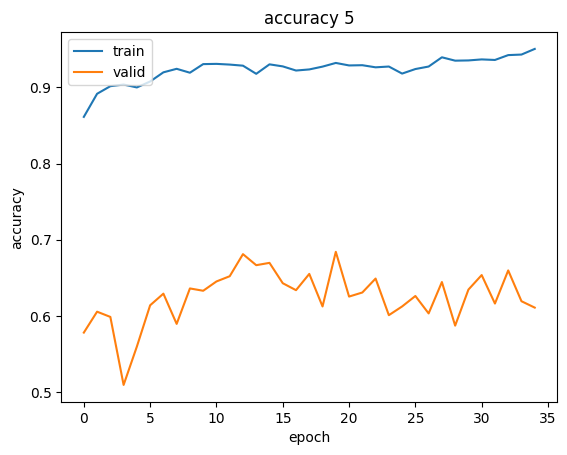

305/305 [==============================] - 3s 9ms/step
Epoch 1/100
151/153 [============================>.] - ETA: 0s - loss: 1540.4756 - accuracy: 0.8263
Epoch 1: val_accuracy improved from -inf to 0.47445, saving model to _pesos_cnn1d.hdf5
153/153 [==============================] - 8s 32ms/step - loss: 1536.9744 - accuracy: 0.8268 - val_loss: 3.4962 - val_accuracy: 0.4744
Epoch 2/100
152/153 [============================>.] - ETA: 0s - loss: 1118.2933 - accuracy: 0.8807
Epoch 2: val_accuracy improved from 0.47445 to 0.60488, saving model to _pesos_cnn1d.hdf5
153/153 [==============================] - 4s 26ms/step - loss: 1117.9331 - accuracy: 0.8807 - val_loss: 6.3317 - val_accuracy: 0.6049
Epoch 3/100
151/153 [============================>.] - ETA: 0s - loss: 946.5332 - accuracy: 0.9029
Epoch 3: val_accuracy did not improve from 0.60488
153/153 [==============================] - 4s 24ms/step - loss: 944.0914 - accuracy: 0.9033 - val_loss: 12.9617 - val_accuracy: 0.5843
Epoch 4/100
1

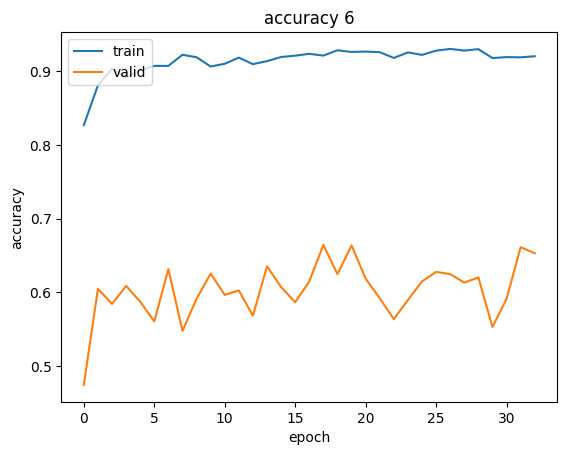

305/305 [==============================] - 3s 9ms/step
Epoch 1/100
151/153 [============================>.] - ETA: 0s - loss: 31329.2246 - accuracy: 0.8343
Epoch 1: val_accuracy improved from -inf to 0.65599, saving model to _pesos_cnn1d.hdf5
153/153 [==============================] - 9s 35ms/step - loss: 31303.8848 - accuracy: 0.8343 - val_loss: 2.6849 - val_accuracy: 0.6560
Epoch 2/100
151/153 [============================>.] - ETA: 0s - loss: 25355.1738 - accuracy: 0.8763
Epoch 2: val_accuracy did not improve from 0.65599
153/153 [==============================] - 4s 24ms/step - loss: 25336.6328 - accuracy: 0.8765 - val_loss: 7.3251 - val_accuracy: 0.6095
Epoch 3/100
153/153 [==============================] - ETA: 0s - loss: 22621.1270 - accuracy: 0.8935
Epoch 3: val_accuracy did not improve from 0.65599
153/153 [==============================] - 4s 24ms/step - loss: 22621.1270 - accuracy: 0.8935 - val_loss: 10.1466 - val_accuracy: 0.6262
Epoch 4/100
153/153 [=======================

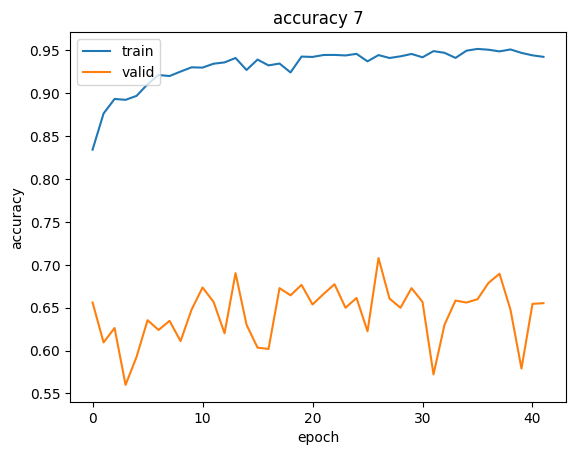

305/305 [==============================] - 3s 9ms/step
Epoch 1/100
151/153 [============================>.] - ETA: 0s - loss: 2219774.5000 - accuracy: 0.8346
Epoch 1: val_accuracy improved from -inf to 0.54233, saving model to _pesos_cnn1d.hdf5
153/153 [==============================] - 8s 32ms/step - loss: 2213069.7500 - accuracy: 0.8354 - val_loss: 6.4163 - val_accuracy: 0.5423
Epoch 2/100
151/153 [============================>.] - ETA: 0s - loss: 1865534.2500 - accuracy: 0.8671
Epoch 2: val_accuracy improved from 0.54233 to 0.54844, saving model to _pesos_cnn1d.hdf5
153/153 [==============================] - 4s 24ms/step - loss: 1863535.5000 - accuracy: 0.8673 - val_loss: 6.2213 - val_accuracy: 0.5484
Epoch 3/100
152/153 [============================>.] - ETA: 0s - loss: 1760170.0000 - accuracy: 0.8775
Epoch 3: val_accuracy did not improve from 0.54844
153/153 [==============================] - 4s 25ms/step - loss: 1762082.3750 - accuracy: 0.8772 - val_loss: 9.6309 - val_accuracy: 0

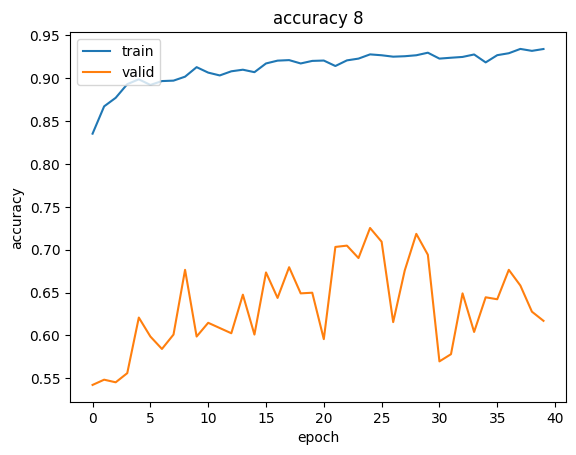

305/305 [==============================] - 3s 9ms/step
Epoch 1/100
153/153 [==============================] - ETA: 0s - loss: 51584852.0000 - accuracy: 0.8436
Epoch 1: val_accuracy improved from -inf to 0.55683, saving model to _pesos_cnn1d.hdf5
153/153 [==============================] - 8s 33ms/step - loss: 51584852.0000 - accuracy: 0.8436 - val_loss: 6.6119 - val_accuracy: 0.5568
Epoch 2/100
153/153 [==============================] - ETA: 0s - loss: 44891872.0000 - accuracy: 0.8717
Epoch 2: val_accuracy improved from 0.55683 to 0.65141, saving model to _pesos_cnn1d.hdf5
153/153 [==============================] - 4s 26ms/step - loss: 44891872.0000 - accuracy: 0.8717 - val_loss: 7.7660 - val_accuracy: 0.6514
Epoch 3/100
153/153 [==============================] - ETA: 0s - loss: 39797072.0000 - accuracy: 0.8875
Epoch 3: val_accuracy did not improve from 0.65141
153/153 [==============================] - 4s 24ms/step - loss: 39797072.0000 - accuracy: 0.8875 - val_loss: 6.5584 - val_accur

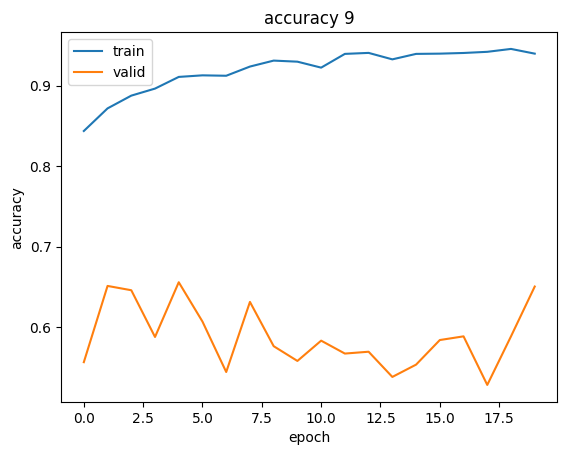

41/41 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           1       0.81      0.54      0.65       631
           2       0.67      0.88      0.76       680

    accuracy                           0.72      1311
   macro avg       0.74      0.71      0.71      1311
weighted avg       0.74      0.72      0.71      1311



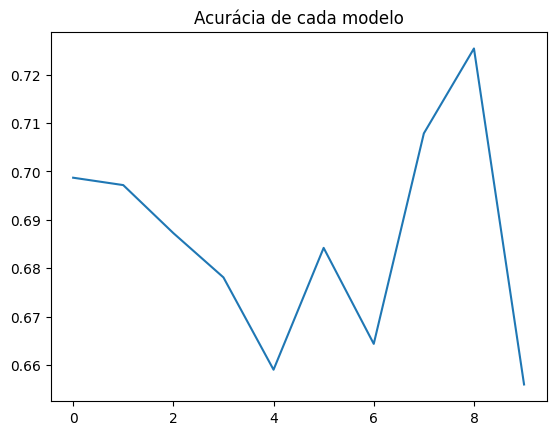

In [54]:
y_train = np.array(y_train, dtype=int)
y_valid = np.array(y_valid, dtype=int)

print(columns)

# checkpoint = ModelCheckpoint('_pesos_cnn1d.hdf5', monitor="val_accuracy", verbose=1,
#                                     save_best_only=True, mode='max')

es = EarlyStopping(monitor="val_accuracy", mode='max', verbose=0, patience=15)

adaboost = AdaBoost()

best_G, best_h, best_acc = adaboost.fit(x_train, y_train, validation_data = (x_valid, y_valid),
                     M=10, epochs=100, batch_size=64, callbacks=es)

generate_report(adaboost, x_valid, y_valid, columns)

plt.plot(best_acc)
plt.title("Acurácia de cada modelo")
plt.show()


In [60]:
def eq_w(model1, model2):
  model1_weights = [layer.get_weights() for layer in model1.layers]
  model2_weights = [layer.get_weights() for layer in model2.layers]

  for (w1, w2) in zip(model1_weights, model2_weights):
      if not all(np.array_equal(x, y) for (x, y) in zip(w1, w2)):
          print("The models have different weights.")
          break
  else:
      print("The models have the same weights.")


In [61]:
eq_w(best_G[0], best_G[1])

The models have different weights.


41/41 [==============================] - 0s 10ms/step


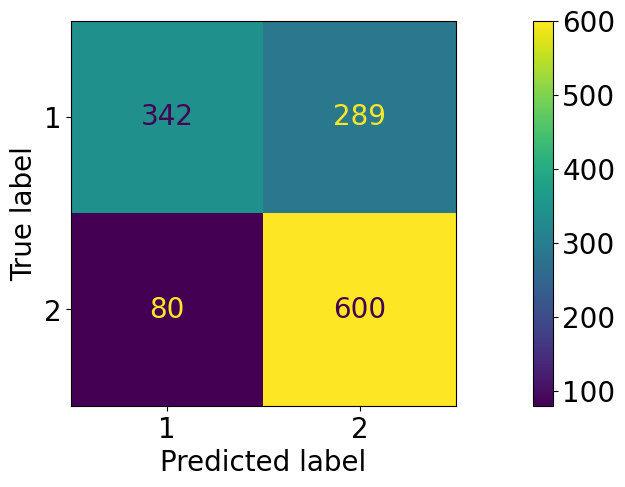

              precision    recall  f1-score   support

           1       0.81      0.54      0.65       631
           2       0.67      0.88      0.76       680

    accuracy                           0.72      1311
   macro avg       0.74      0.71      0.71      1311
weighted avg       0.74      0.72      0.71      1311



In [67]:
y_pred = adaboost.predict(x_valid)
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['1', '2']
y_pred = y_pred.idxmax(axis=1)
y_te = pd.DataFrame(y_valid)
y_te.columns = ['1', '2']
y_te = y_te.idxmax(axis=1)

plt.rcParams['figure.figsize']=(20,5)
plt.rcParams.update({'font.size': 20})

cf_matrix = confusion_matrix(y_te, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['1','2'])
cm_display.plot()
plt.show()

relatorio = classification_report(y_te, y_pred, target_names = ['1','2'])
print(relatorio)

69/69 [==============================] - 1s 8ms/step


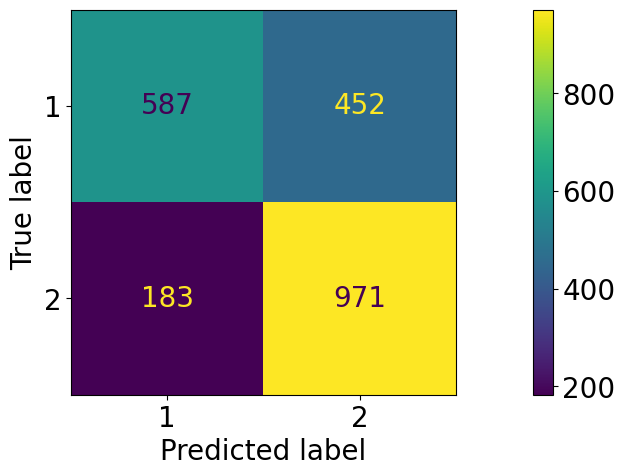

              precision    recall  f1-score   support

           1       0.76      0.56      0.65      1039
           2       0.68      0.84      0.75      1154

    accuracy                           0.71      2193
   macro avg       0.72      0.70      0.70      2193
weighted avg       0.72      0.71      0.70      2193



In [68]:
y_pred = adaboost.predict(x_test)
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['1', '2']
y_pred = y_pred.idxmax(axis=1)
y_te = pd.DataFrame(y_test)
y_te.columns = ['1', '2']
y_te = y_te.idxmax(axis=1)

plt.rcParams['figure.figsize']=(20,5)
plt.rcParams.update({'font.size': 20})

cf_matrix = confusion_matrix(y_te, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['1','2'])
cm_display.plot()
plt.show()

relatorio = classification_report(y_te, y_pred, target_names = ['1','2'])
print(relatorio)

In [ ]:
# |   iter    |  target   | batch_... | dense_... |  dropout  | learni... | lstm_l... | neuron... | optimizer |   units
# | 36        | 0.73      | 8.489     | 3.39      | 0.4147    | 0.6446    | 3.537     | 6.876     | 3.949     | 3.693
# | 108       | 0.701     | 6.267     | 3.928     | 0.4027    | 0.9463    | 2.375     | 5.145     | 4.466     | 5.031
# evaluate_network(batch_size = 8.489, dense_layers = 3.39, dropout = 0.4147, learning_rate = 0.6446, lstm_layers = 3.537, neurons_ini = 6.876,
#                  optimizer = 3.949, units  = 3.693)

# evaluate_network(batch_size = 6.267, dense_layers = 3.928 , dropout = 0.4027, learning_rate = 0.9463 , lstm_layers = 2.375 , neurons_ini = 5.145,
#                  optimizer = 4.466, units  = 5.031)

In [ ]:
model = load_model('/content/_melhores_pesos.h5')

In [ ]:
for i,signal in enumerate(raw_x_test):
  s, _ = split_beats([signal], [raw_y_test[i]], bps)
  raw_x_test[i] = norm_len_2(s, lim)

### Usando a moda

In [ ]:
y_pred = []
for signal in raw_x_test:

  prediction = model.predict(np.array(signal))
  prediction = pd.DataFrame(prediction)
  prediction.columns = [1,2]
  prediction = prediction.idxmax(axis=1)
  val = prediction.mode()[0]
  y_pred.append(val)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

plt.rcParams['figure.figsize']=(2,2)
plt.rcParams.update({'font.size': 10})

cf_matrix = confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['1','2'])
cm_display.plot()

In [ ]:
from sklearn.metrics import classification_report

relatorio = classification_report(y_test, y_pred, target_names = ['1','2'])
print(relatorio)

### Usando a soma das probabilidades

In [ ]:
y_pred = []
for signal in raw_x_test:

  prediction = model.predict(np.array(signal))
  prediction = np.sum(prediction, axis=0)
  prediction = pd.DataFrame([prediction])
  prediction.columns = [1,2]
  val = prediction.idxmax(axis=1)[0]
  y_pred.append(val)

In [ ]:
y_pred

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

plt.rcParams['figure.figsize']=(2,2)
plt.rcParams.update({'font.size': 10})

cf_matrix = confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['1','2'])
cm_display.plot()

In [ ]:
from sklearn.metrics import classification_report

relatorio = classification_report(y_test, y_pred, target_names = ['1','2'])
print(relatorio)